## Imports

In [2]:
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
pd.options.display.float_format = '{:,}'.format
sns.set()

In [3]:
ghg = pd.read_csv('./datasets/climate_trace_total.csv', parse_dates=['start','end'])

FileNotFoundError: [Errno 2] No such file or directory: './datasets/climate_trace_total.csv'

In [4]:
ghg_unfcc= pd.read_csv('./datasets/ghg_unfccc.csv', sep=';')

In [5]:
pop = pd.read_csv('./datasets/population.csv', delimiter=',',header=2)

In [6]:
pib = pd.read_csv('./datasets/pib.csv', delimiter=',',header=2)

In [7]:
url='https://pkgstore.datahub.io/JohnSnowLabs/country-and-continent-codes-list/country-and-continent-codes-list-csv_csv/data/b7876b7f496677669644f3d1069d3121/country-and-continent-codes-list-csv_csv.csv'
country_codes = pd.read_csv(url, usecols=['Three_Letter_Country_Code','Continent_Name'])

## Data preparation

In [8]:
country_codes.rename(columns={'Three_Letter_Country_Code':'country',
                              'Continent_Name':'continent'},inplace=True)


In [ ]:
# Drop duplicates Asia/Europe: Turkey and Russia
country_codes = country_codes.drop(192)
country_codes = country_codes.drop(234)

In [ ]:
## Add continent
ghg = ghg.merge(country_codes, on='country', how='left')
# Adding continent for Kosovo
ghg['continent'] = ghg['continent'].fillna('Europe')

In [ ]:
# Add year column
ghg['year'] = pd.DatetimeIndex(ghg['start']).year.astype(str)

In [ ]:
# Add million of tons of co2e
ghg['million_tonnes_co2e'] = ghg['Tonnes Co2e'] / 1000000

In [ ]:
eu = ['Austria','Belgium', 'Bulgaria', 'Cyprus', 'Czechia', 'Germany',
       'Denmark', 'Spain', 'Estonia', 'Finland', 'France','Greece', 
      'Croatia', 'Hungary','Ireland','Italy', 'Lithuania', 'Luxembourg', 
      'Latvia','Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania',
       'Slovakia', 'Slovenia', 'Sweden']
# add eu
ghg["eu"] = np.where(ghg["country_full"].isin(eu), 1, 0)

In [ ]:
# Preparing population df
pop_15_20= pop.loc[:, ['Country Code','2015','2016','2017','2018','2019','2020']]
pop_15_20.rename(columns={'Country Code':'country'},inplace=True)
pop_15_20=pop_15_20.set_index('country').stack().reset_index(name='population').rename(columns={'level_1':'year'})


In [ ]:
# Preparing pip df

pib_15_20= pib.loc[:, ['Country Code','2015','2016','2017','2018','2019','2020']]
pib_15_20.rename(columns={'Country Code':'country'},inplace=True)
pib_15_20= pib_15_20.set_index('country').stack().reset_index(name='GDP').rename(columns={'level_1':'year'})



In [ ]:
# Joining pop and pib to ghg
ghg = ghg.merge(pib_15_20, on=['country','year'], how='left')
ghg = ghg.merge(pop_15_20, on=['country','year'], how='left')


In [ ]:
# Add GDP per capita and million tonnes co2eq per capita
ghg['GDP_per_cap'] = ghg['GDP'] / ghg['population']

In [ ]:
# Replace United Kingdom name
ghg['country_full']= ghg['country_full'].replace('United Kingdom of Great Britain and Northern Ireland', 'United Kingdom')

## Analysis

### 1. Biggest polluting countries

In [ ]:
ghg_country= ghg.groupby(['country_full','continent','year'])[['million_tonnes_co2e']].sum().reset_index().sort_values(by=['million_tonnes_co2e'], ascending=False)

In [ ]:
# EU emissions
ghg_eu= ghg.groupby(['eu','year'])[['million_tonnes_co2e']].sum().reset_index().sort_values(by=['year'], ascending=False)
ghg_eu= ghg_eu[ghg_eu.eu==1] 
ghg_eu=ghg_eu.loc[:,['year','million_tonnes_co2e']]
ghg_eu.columns=['year','EU27']

In [ ]:
# Most polluting countries (no EU)
most_pollutant_countries_list= (list(ghg_country.groupby(['country_full','continent'])[['million_tonnes_co2e']]
                                .sum().reset_index().sort_values(by=['million_tonnes_co2e'], ascending=False)
                                .head(7)['country_full'])
                          )

for element in most_pollutant_countries_list:
    if element in eu:
        most_pollutant_countries_list.remove(element)

In [ ]:
most_polluting_df = ghg_country[ghg_country['country_full'].isin(most_pollutant_countries)]

In [ ]:
most_polluting_df= most_polluting_df.pivot_table(values='million_tonnes_co2e',columns='country_full',index='year').reset_index()

In [ ]:
# merge most polluting and EU
most_polluting_df= most_polluting_df.merge(ghg_eu, on='year')


In [ ]:
# Rest countries sum
rest_countries = ghg_country[ghg_country['country_full'].isin(most_pollutant_countries + eu) ==False ]
ghg_rest_countries = rest_countries.groupby(['country_full','year'])[['million_tonnes_co2e']].sum().reset_index()
ghg_rest_countries = ghg_rest_countries.groupby('year')[['million_tonnes_co2e']].sum()
ghg_rest_countries= ghg_rest_countries.reset_index()
ghg_rest_countries.columns=['year','Other countries']

In [ ]:
# merge most polluting and other countries
most_polluting_df= most_polluting_df.merge(ghg_rest_countries, on='year')


In [ ]:
# Sort rows
most_polluting_df= most_polluting_df.set_index('year').T.sort_values(by='2020',ascending=False).T

In [ ]:
sns.set()
sns.set_style("whitegrid")

fig, ax= plt.subplots(figsize=(10,6))

ax=sns.lineplot(data=most_polluting_df,linestyle='solid')
ax.set_title('Carbon majors (2015-2020)', fontsize=15)
ax.set_xlim([0,5])
ax.set_ylim(0)
ax.set_ylabel('Million tonnes Co2 equivalent')
ax.set_xlabel(None)
plt.legend(loc='center left')
plt.annotate('Source: Climate Trace', (0.08,-0.01), (-80,-20), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points', va='top')

plt.show()


In [ ]:
most_polluting_df_2 = pd.DataFrame(most_polluting_df.stack()).reset_index()
most_polluting_df_2.columns = ['year','country','million_tonnes_co2e']

In [ ]:
sns.set()
sns.set_style("whitegrid")

fig, ax= plt.subplots(figsize=(10,6))
sns.set_context(rc={"lines.linewidth": 2})
ax= sns.barplot(x="year", y="million_tonnes_co2e", data=most_polluting_df_2, hue='country')
ax.set_title('Carbon majors (2015-2020)', fontsize=15)
ax.set_ylabel('Million tonnes Co2 equivalent')
ax.set_xlabel(None)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Hide spines
ax.spines[:].set_visible(False)



plt.show()

### 2. Biggest polluting countries by year 

In [ ]:
def most_polluting_countries(year='all'):
    sns.set()
    sns.set_style("whitegrid")


    if year =='all':
        
        ghg_country = ghg
        ghg_country= ghg_country.groupby(['country_full','continent','year'])[['million_tonnes_co2e']].sum().reset_index()
        ghg_country= ghg_country.groupby(['country_full','continent'])[['million_tonnes_co2e']].mean().sort_values(by='million_tonnes_co2e',ascending=False)


    else:
        ghg_country = ghg[ghg.year ==year]
        ghg_country= ghg_country.groupby(['country_full','continent'])[['million_tonnes_co2e']].sum().reset_index().sort_values(by=['million_tonnes_co2e'], ascending=False)

    
    fig, ax= plt.subplots(figsize=(10,6))
    
    ax = sns.barplot(y="country_full", x="million_tonnes_co2e", hue="continent", 
                 data=ghg_country.head(20).reset_index(),dodge=False)
    

    if year!='all':
        ax.set_title('Carbon majors ({year})'.format(year=year), fontsize=15)
    else:
        ax.set_title('Carbon majors (2015-2020)', fontsize=15)
    
    ax.set_ylabel(None)
    ax.set_xlabel('Million tonnes Co2 equivalent')
    plt.legend(loc='center right')
    plt.annotate('Source: Climate Trace', (0.08,-0.01), (-80,-20), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points', va='top')

    ax.spines[:].set_visible(False)

    plt.show()

In [ ]:
most_polluting_countries('2020')

### 3. Most pollutant sectors

In [ ]:
def emissions_sector(year, country='Global'):
    sns.set_style("whitegrid")

    sns.set_palette(reversed(sns.color_palette("Blues_d", 9)), 9)

    if country=='Global':
        emissions_sector_ghg = ghg[ghg.year ==year]
    else:
        emissions_sector_ghg = ghg[(ghg.year ==year) & (ghg.country_full==country)]

    emissions_sector_ghg= emissions_sector_ghg.groupby(['sector'])[['million_tonnes_co2e']].sum().sort_values(by='million_tonnes_co2e', ascending=False)
    
    fig, ax= plt.subplots(figsize=(10,6))
    ax = sns.barplot(y="sector", x="million_tonnes_co2e", hue="sector", 
                 data=emissions_sector_ghg.head(20).reset_index(),dodge=False)
    
    ax.set_title('{country} emissions by sector ({year})'.format(country=country, year=year), fontsize=15)
    ax.set_ylabel(None)
    ax.set_xlabel('Million tonnes Co2 equivalent')
    ax.get_legend().remove()
    plt.annotate('Source: Climate Trace', (0.08,-0.01), (-80,-20), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points', va='top')
    ax.spines[:].set_visible(False)

    plt.show()

In [ ]:
emissions_sector('2015','Spain')

### 4. Most pollutant subsectorr sectors

In [ ]:
def emissions_subsector(year, country='Global'):
    sns.set()
    sns.set_style("whitegrid")


    if country=='Global':
        emissions_sector_subsector = ghg[ghg.year ==year]
    else:
        emissions_sector_subsector = ghg[(ghg.year ==year) & (ghg.country_full==country)]
        
    emissions_sector_subsector = emissions_sector_subsector.groupby(['sector','subsector'])[['million_tonnes_co2e']].sum().sort_values(by='million_tonnes_co2e', ascending=False)

    
    fig, ax= plt.subplots(figsize=(10,6))
    
    ax = sns.barplot(y="subsector", x="million_tonnes_co2e", hue="sector", 
                     data=emissions_sector_subsector.head(20).reset_index(),dodge=False)
    
    ax.set_title('{country} emissions by subsector ({year})'.format(country=country, year=year), fontsize=15)
    ax.set_ylabel(None)
    ax.set_xlabel('Million tonnes Co2 equivalent')
    plt.legend(loc='center right', title="Sectors")
    plt.annotate('Source: Climate Trace', (0.08,-0.01), (-80,-20), fontsize=8, 
                 xycoords='axes fraction', textcoords='offset points', va='top')
    ax.spines[:].set_visible(False)

    plt.show()

In [ ]:
emissions_subsector('2020','China')

### 5. Sectors and subsectors

In [ ]:
def sector_stacked(df, year, sector, country ='all'):
    sns.set()
    sns.set_style("whitegrid")

    fig, ax= plt.subplots(figsize=(10,6))
    
    if country=='all':
        df_year_sector = df[(df.year==year) & (df.sector==sector)]
        df_year_sector=(df_year_sector.groupby('subsector')[['million_tonnes_co2e']].sum().
         sort_values(by='million_tonnes_co2e', ascending=False).T)
        df_year_sector.plot.barh(stacked=True, ax=ax, rot=None)
        
        ax.set_title('Global GHG emissions from {sector} ({year})'.format(sector=sector, year=year),fontsize=15)
    
    else:
        df_year_sector = df[(df.year==year) & (df.sector==sector) & (df.country_full==country)]
        df_year_sector=(df_year_sector.groupby('subsector')[['million_tonnes_co2e']].sum().
         sort_values(by='million_tonnes_co2e', ascending=False).T)
        df_year_sector.plot.barh(stacked=True, ax=ax, rot=None)
        
        ax.set_title("{country}'s GHG emissions from {sector} ({year})".format(sector=sector,country=country, year=year),fontsize=15)
        
    ax.set_xlabel('Million tonnes Co2 equivalent')
    ax.set_ylabel(None)
    ax.set_yticklabels([])
    
    if len(df_year_sector.columns) > 6:
        plt.legend(loc="upper right", ncol=3)
    elif len(df_year_sector.columns) >3:
        plt.legend(loc="upper right", ncol=2)
    else:
         plt.legend(loc="upper right", ncol=len(df_year_sector.columns))
    plt.annotate('Source: Climate Trace', (0.14,-0.01), (-80,-20), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points', va='top')
    
    ax.grid(axis='y')
    ax.spines[:].set_visible(False)



    plt.show()
    

In [ ]:
sector_stacked(ghg,'2015','oil and gas', 'Spain')

In [ ]:
def emissions_country_stacked(country):
    sns.set_style("whitegrid")

    sns.set_palette(reversed(sns.color_palette("Blues_d", 6)), 6)
    
    country_df = ghg[ghg.country_full==country]
    country_df =country_df.groupby(['year','sector'])[['million_tonnes_co2e']].sum().reset_index()
    country_df= country_df.pivot_table(values='million_tonnes_co2e',columns='sector',index='year')
    
    country_df['energy and power'] = country_df['oil and gas'] + country_df['power'] 
    country_df['manufacturing and industrial'] = country_df['manufacturing'] + country_df['extraction'] 
    country_df['transport and maritime'] = country_df['transport'] + country_df['maritime'] 
    
    fig, ax= plt.subplots(figsize=(10,6))
    
    ax.bar(country_df.index, country_df['energy and power'], label='Energy and Power')
    ax.bar(country_df.index, country_df['manufacturing and industrial'], label='Manufacturing and Industrial', bottom=country_df['energy and power'])
    ax.bar(country_df.index, country_df['transport and maritime'], label='Transport and Maritime', bottom=country_df['energy and power'] + country_df['manufacturing and industrial'])
    ax.bar(country_df.index, country_df['buildings'], label='Buildings', bottom=country_df['energy and power'] + country_df['manufacturing and industrial'] + country_df['transport and maritime'])
    ax.bar(country_df.index, country_df['agriculture'], label='Agriculture', bottom=country_df['energy and power'] + country_df['manufacturing and industrial'] + country_df['transport and maritime'] + country_df['buildings'])
    ax.bar(country_df.index, country_df['waste'], label='Waste', bottom=country_df['energy and power'] + country_df['manufacturing and industrial'] + country_df['transport and maritime'] + country_df['buildings'] + country_df['agriculture']
    )
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.8))
    
    ax.set_title("{country}'s GHG emissions by Year and Sector".format(country=country),fontsize=15)
    ax.set_ylabel('Million tonnes Co2 equivalent')
    ax.set_xlabel(None)
    ax.grid(axis='x')
    ax.spines[:].set_visible(False)
    plt.annotate('Source: Climate Trace', (0.14,-0.01), (-80,-20), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points', va='top')

    
    
    plt.show()

In [ ]:
emissions_country_stacked('Sweden')

### 6. Maps

#### Global metrics

In [21]:
metrics=['million_tonnes_co2e','co2eq_per_cap','GDP','GDP_per_cap', 'population']

In [102]:
def calculate_percentiles (df, metric):
    
    percentiles=[0]
    if metric == 'million_tonnes_co2e' :
        values = [100, 1000, 2000, 3000]
        for val in values:
            percentile = stats.percentileofscore(df[metric], val) / 100
            percentiles.append(percentile)
            
    elif metric == 'co2eq_per_cap' :
        values = [5, 10, 20, 30]
        for val in values:
            percentile = stats.percentileofscore(df[metric], val) / 100
            percentiles.append(percentile)
            
    elif metric == 'GDP' :
        values = [(0.25*10**12),(0.5*10**12),(1.5*10**12),(3*10**12)]
        for val in values:
            percentile = stats.percentileofscore(df[metric], val) / 100
            percentiles.append(percentile)
            
    elif metric == 'GDP_per_cap' :
        values = [10000,20000,30000,60000]
        for val in values:
            percentile = stats.percentileofscore(df[metric], val) / 100
            percentiles.append(percentile)
            
    elif metric == 'population' :
        values = [(70*10**6),(100*10**6),(150*10**6),(250*10**6)]
        for val in values:
            percentile = stats.percentileofscore(df[metric], val) / 100
            percentiles.append(percentile)
            
    percentiles.append(1)

    values = values[::-1]
    if metric =='population':
        values = [int(val/ 1000000) for val in values]
        
    if metric =='GDP':
        values = [int(val/ 100000000000) for val in values]
              
    values = [str(val) for val in values]
    legend_values = list(range(len(values) + 1))
    
    legend_values[0] = '> ' + values[0]
    legend_values[1] = values[1]+ ' - ' + values[0]
    legend_values[2] = values[2]+ ' - ' + values[1]
    legend_values[3] = values[3]+ ' - ' + values[2]
    legend_values[4] = '< ' + values[3]
    print(legend_values)
        
        
    return legend_values, percentiles

In [103]:
def df_metric(metric, year):
    
    ghg_year = ghg[ghg.year ==year]
    
    if metric =='million_tonnes_co2e':
        ghg_map= ghg_year.groupby(['country_full'])[['million_tonnes_co2e']].sum().reset_index().sort_values(by=['million_tonnes_co2e'], ascending=False)
        legend_values, percentiles = calculate_percentiles(ghg_map, metric)
        ghg_map['range']=pd.qcut(ghg_map['million_tonnes_co2e'], q=percentiles, precision = 0, labels=False)
        ghg_map = ghg_map.sort_values(by='range', ascending=False)
        ghg_map['million_tonnes_co2e'] =ghg_map['million_tonnes_co2e'].round(1)
        ghg_map['million_tonnes_co2e'] =ghg_map.apply(lambda x: "{:,}".format(x['million_tonnes_co2e']), axis=1)
        ghg_map['million_tonnes_co2e'] = ghg_map['million_tonnes_co2e'].astype(str)
        ghg_map['million_tonnes_co2e']= ghg_map['million_tonnes_co2e'].replace({'nan':'No data'})
 

    elif metric =='co2eq_per_cap':
        ghg_emissions= ghg_year.groupby(['country_full'])[['Tonnes Co2e']].sum().reset_index().sort_values(by=['Tonnes Co2e'], ascending=False)
        population = ghg_year[['country_full','population']].drop_duplicates()
        ghg_map = ghg_emissions.merge(population, on='country_full', how='left')
        ghg_map['co2eq_per_cap'] = ghg_map['Tonnes Co2e'] / ghg_map['population']
        ghg_map_not_null = ghg_map[ghg_map['co2eq_per_cap'].notnull()].reset_index(drop=True)
        legend_values, percentiles = calculate_percentiles(ghg_map_not_null, metric)
        ghg_map_not_null['range']=pd.qcut(ghg_map_not_null['co2eq_per_cap'], q=percentiles, precision = 0,labels=False)
        ghg_map_not_null=ghg_map_not_null[['country_full','range']]
        ghg_map = ghg_map.merge(ghg_map_not_null, how='left')
        ghg_map = ghg_map.sort_values(by='range', ascending=False)
        ghg_map['co2eq_per_cap'] =ghg_map['co2eq_per_cap'].round(1)
        ghg_map['co2eq_per_cap'] =ghg_map.apply(lambda x: "{:,}".format(x['co2eq_per_cap']), axis=1)
        ghg_map['co2eq_per_cap'] = ghg_map['co2eq_per_cap'].astype(str)
        ghg_map['co2eq_per_cap']= ghg_map['co2eq_per_cap'].replace({'nan':'No data'})
        if (len(ghg_map.range.unique()) > len(legend_values)):
            legend_values.append('No data')
        dictionary = dict(zip(ghg_map['range'].unique(), legend_values))
        ghg_map= ghg_map.replace({"range": dictionary})


        
    elif metric =='GDP':
        ghg_map = ghg_year[['country_full','year','GDP']].drop_duplicates()
        ghg_map_not_null = ghg_map[ghg_map['GDP'].notnull()].reset_index(drop=True)
        legend_values, percentiles = calculate_percentiles(ghg_map_not_null, metric)
        ghg_map_not_null['range']=pd.qcut(ghg_map_not_null['GDP'], q=percentiles, precision = 0,labels=False)
        ghg_map_not_null=ghg_map_not_null[['country_full','range']]
        ghg_map = ghg_map.merge(ghg_map_not_null, how='left')
        ghg_map = ghg_map.sort_values(by='range', ascending=False)
        ghg_map['GDP'] =(ghg_map['GDP'] / 1000000000000).round(1)
        ghg_map['GDP'] =ghg_map.apply(lambda x: "{:,}".format(x['GDP']), axis=1)
        ghg_map['GDP'] = ghg_map['GDP'].astype(str)
        ghg_map['GDP']= ghg_map['GDP'].replace({'nan':'No data'})
        if (len(ghg_map.range.unique()) > len(legend_values)):
            legend_values.append('No data')
        dictionary = dict(zip(ghg_map['range'].unique(), legend_values))
        ghg_map= ghg_map.replace({"range": dictionary})

    
    elif metric =='GDP_per_cap':
        ghg_map = ghg_year[['country_full','year','GDP_per_cap']].drop_duplicates()
        ghg_map_not_null = ghg_map[ghg_map['GDP_per_cap'].notnull()].reset_index(drop=True)
        legend_values, percentiles = calculate_percentiles(ghg_map_not_null, 'GDP_per_cap')
        ghg_map_not_null['range']=pd.qcut(ghg_map_not_null['GDP_per_cap'], q=percentiles, precision = 0,labels=False)
        ghg_map_not_null=ghg_map_not_null[['country_full','range']]
        ghg_map = ghg_map.merge(ghg_map_not_null, how='left')
        ghg_map = ghg_map.sort_values(by='range', ascending=False)
        ghg_map['GDP_per_cap'] = ghg_map['GDP_per_cap'].round(0).astype('Int32')
        ghg_map['GDP_per_cap'] =ghg_map.apply(lambda x: "{:,}".format(x['GDP_per_cap']), axis=1)
        ghg_map['GDP_per_cap'] =ghg_map['GDP_per_cap'].astype(str)
        ghg_map['GDP_per_cap']= ghg_map['GDP_per_cap'].replace({'<NA>':'No data'})
        if (len(ghg_map.range.unique()) > len(legend_values)):
            legend_values.append('No data')
        dictionary = dict(zip(ghg_map['range'].unique(), legend_values))
        ghg_map= ghg_map.replace({"range": dictionary})
        
    elif metric =='population':
        ghg_map = ghg_year[['country_full','year','population']].drop_duplicates()
        ghg_map_not_null = ghg_map[ghg_map['population'].notnull()].reset_index(drop=True)
        legend_values, percentiles = calculate_percentiles(ghg_map_not_null, 'population')
        ghg_map_not_null['range']=pd.qcut(ghg_map_not_null['population'], q=percentiles, precision = 0,labels=False)
        ghg_map_not_null=ghg_map_not_null[['country_full','range']]
        ghg_map = ghg_map.merge(ghg_map_not_null, how='left')
        ghg_map['population'] = ghg_map['population'].round(0).astype('Int32')
        ghg_map['population'] =ghg_map.apply(lambda x: "{:,}".format(x['population']), axis=1)
        ghg_map['population'] = ghg_map['population'].astype(str)
        ghg_map['population']= ghg_map['population'].replace({'<NA>':'No data'})
        ghg_map = ghg_map.sort_values(by='range', ascending=False)
        if (len(ghg_map.range.unique()) > len(legend_values)):
            legend_values.append('No data')
        dictionary = dict(zip(ghg_map['range'].unique(), legend_values))
        ghg_map= ghg_map.replace({"range": dictionary})
        
        
               
    return ghg_map


        

In [104]:
def show_map(metric, year):
    
    scale = ['rgb(8,48,107)','rgb(33,113,181)','rgb(66,146,198)','rgb(158,202,225)','rgb(222,235,247)','grey']


    ghg_map = df_metric(metric, year)
    
    hover_data = {metric:True,'country_full':False,'range':False}
    
    
    
    if (metric =='million_tonnes_co2e'):
        title = 'GHG emissions'
        label = 'GHG emissions'
        measure= 'MTCo2eq'
        source = 'Source: <a href="https://www.climatetrace.org/">\nClimate Trace</a>'
        
    elif metric =='co2eq_per_cap':
        title = 'GHG emissions per capita'
        label = 'GHG emissions per person'
        measure= 'TCo2eq per person'
        source = 'Source: <a href="https://www.climatetrace.org/">\nClimate Trace</a>, <a href="https://data.worldbank.org/">\nWorld Bank</a>'
        
    elif metric =='GDP':
        title = 'Gross Domestic Product (GDP)'
        label = 'GDP'
        measure ='Trillion $US'
        source = 'Source: <a href="https://data.worldbank.org/">\nWorld Bank</a>'

    elif metric =='GDP_per_cap':
        title = 'World GDP per capita'
        label ='GDP per person'
        measure = '$US per person'
        source = 'Source: <a href="https://data.worldbank.org/">\nWorld Bank</a>'
    
    elif metric =='population':
        title = 'World Population'
        label ='Population'
        measure='Million people'   
        source = 'Source: <a href="https://data.worldbank.org/">\nWorld Bank</a>'
    

    fig = px.choropleth(ghg_map, locations="country_full", 
                        locationmode='country names', color='range',
                        hover_name="country_full",
                        hover_data=hover_data,
                        color_discrete_sequence=scale,
                        labels={metric: label})
      
            
            
    fig.update_layout(autosize=False, 
                      width=800, 
                      height=400,
                      font_family="sans-serif",
                      title_font_family="sans-serif",
                      
                      margin=dict(
                                  l=20,
                                  r=20,
                                  b=20,
                                  t=20,
                                  pad=5),
                        
                      hoverlabel=dict(
                                  bgcolor="white",
                                  font_size=10,
                                  font_family="sans-serif"
                                    ),
                      
                      title=dict(
                                 text= "{title} ({year})".format(title = title, year=year),
                                 xanchor = 'center',
                                 x=0.5,
                                 yanchor = 'top',
                                 y=0.95),
                      
                      geo=dict(
                              showframe=True,
                                lataxis=dict(range=[-55,90]),
                              showlakes=False),
                      
                      legend=dict(
                                y=0.07,
                                font_size=10,
                                title=measure,
                                x=0.015,
                                bordercolor="grey",
                                borderwidth=0.5
                                ),
                      
                      annotations = [dict(
                                x=0.015,
                                y=0,
                                text=source,
                                font_size=10,
                                font_family='sans-serif',
                                showarrow = False)]
                     )
    
    fig.write_html("./visualisations/{metric}_{year}.html".format(metric=metric, year=year))

    fig.show()
    

['> 30', '20 - 30', '10 - 20', '5 - 10', '< 5']


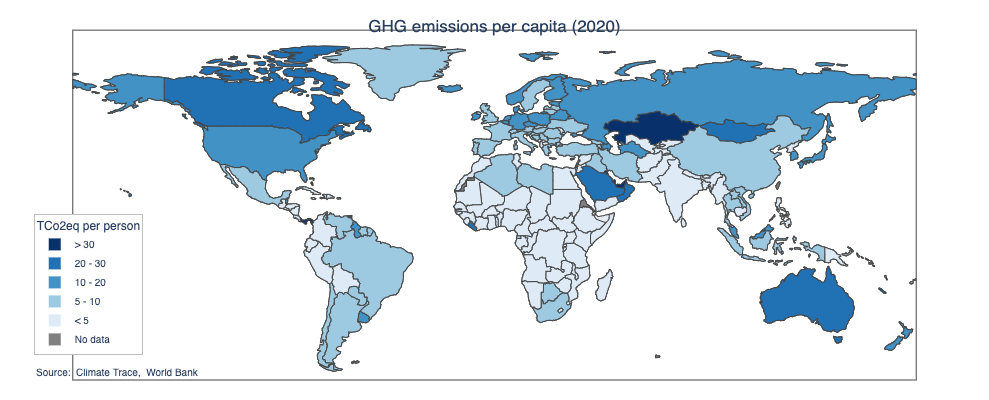

In [105]:
show_map('co2eq_per_cap', '2020')

#### Maps sector

In [4376]:
def percentiles_sector (df, sector):
    
    percentiles=[0]
    
    if sector == 'agriculture':
        values = [50, 100, 200, 500]     
    if sector == 'buildings':
        values = [25, 50, 100, 500]
    if sector == 'extraction':
        values = [1, 3, 5, 7]  
    if sector == 'manufacturing':
        values = [30, 100, 500, 1000]
    if sector == 'maritime':
        values = [1, 10, 50, 100]
    if sector == 'oil and gas':
        values = [25, 100, 500, 1000]
    if sector == 'power':
        values = [25, 50, 100, 1000]
    if sector == 'transport':
        values = [25, 50, 100, 500]     
    if sector == 'waste':
        values = [20, 50, 100, 500]
        
    for val in values:
        percentile = stats.percentileofscore(df['million_tonnes_co2e'], val) / 100
        percentiles.append(percentile)
    
    percentiles.append(1)
            
    values = values[::-1]
    values = [str(val) for val in values]
    legend_values = list(range(len(values) + 1))
    
    legend_values[0] = '> ' + values[0]
    legend_values[1] = values[1]+ ' - ' + values[0]
    legend_values[2] = values[2]+ ' - ' + values[1]
    legend_values[3] = values[3]+ ' - ' + values[2]
    legend_values[4] = '< ' + values[3]
    return legend_values, percentiles

In [4442]:
def df_sector(sector, year):
    
    ghg_year = ghg[(ghg.year ==year) & (ghg.sector ==sector)]
    
    
    ghg_map= ghg_year.groupby(['country_full'])[['million_tonnes_co2e']].sum().reset_index().sort_values(by=['million_tonnes_co2e'], ascending=False)
    legend_values, percentiles  = percentiles_sector(ghg_map, sector)
        
    ghg_map['range']=pd.qcut(ghg_map['million_tonnes_co2e'], q=percentiles, precision = 0, labels=False)
    ghg_map = ghg_map.sort_values(by='range', ascending=False)
    ghg_map['million_tonnes_co2e'] =ghg_map['million_tonnes_co2e'].round(1)
    ghg_map['million_tonnes_co2e'] =ghg_map.apply(lambda x: "{:,}".format(x['million_tonnes_co2e']), axis=1)
    ghg_map['million_tonnes_co2e'] = ghg_map['million_tonnes_co2e'].astype(str)
    ghg_map['million_tonnes_co2e']= ghg_map['million_tonnes_co2e'].replace({'nan':'No data'})
    dictionary = dict(zip(ghg_map['range'].unique(), legend_values))
    dictionary['No data'] ='No data'
    ghg_map= ghg_map.replace({"range": dictionary})
    
    ghg_subsector = ghg_year.groupby(['country_full','subsector'])[['million_tonnes_co2e']].sum().reset_index().sort_values(by=['million_tonnes_co2e'], ascending=False)
    ghg_subsector= ghg_subsector.pivot_table(values='million_tonnes_co2e',columns='subsector',index='country_full').reset_index()
    ghg_subsector = ghg_subsector.round(1)
    ghg_map= ghg_map.merge(ghg_subsector, on='country_full',how='left')
    
    return ghg_map


        

In [4465]:
def show_map_sector(sector, year):
    scale = ['rgb(8,48,107)','rgb(33,113,181)','rgb(66,146,198)','rgb(158,202,225)','rgb(222,235,247)','grey']

    ghg_map = df_sector(sector, year)
    hover_data = {'million_tonnes_co2e':True, 'country_full':False,'range':False,}

    for col in ghg_map.columns[3:]:
        hover_data[col]=True
    

    title = 'GHG emissions'
    label = 'Total GHG emissions'
    measure= 'MTCo2eq'
    source = 'Source: <a href="https://www.climatetrace.org/">\nClimate Trace</a>'

    fig = px.choropleth(ghg_map, locations="country_full", 
                        locationmode='country names', color='range',
                        hover_name="country_full",
                        hover_data=hover_data,
                        color_discrete_sequence=scale,
                        labels={'million_tonnes_co2e': label})
                       
    fig.update_layout(autosize=False, 
                      width=800, 
                      height=400,
                      font_family="sans-serif",
                      title_font_family="sans-serif",
                      
                      margin=dict(
                                  l=20,
                                  r=20,
                                  b=20,
                                  t=20,
                                  ),
                        
                      hoverlabel=dict(
                                  bgcolor="white",
                                  font_size=10,
                                  font_family="sans-serif"
                                    ),
                      
                      title=dict(
                                 text= "{title} from {sector} ({year})".format(title = title, sector=sector, year=year),
                                 xanchor = 'center',
                                 x=0.5,
                                 yanchor = 'top',
                                 y=0.95),
                      
                      geo=dict(
                              showframe=True,
                                lataxis=dict(range=[-55,90]),
                              showlakes=False),
                      
                      legend=dict(
                                y=0.07,
                                font_size=10,
                                title=measure,
                                x=0.015,
                                bordercolor="grey",
                                borderwidth=0.5
                                ),
                      
                      annotations = [dict(
                                x=0.015,
                                y=0,
                                text=source,
                                font_size=10,
                                font_family='sans-serif',
                          
                                showarrow = False)])
    

    fig.show()
    fig.write_html("./visualisations/{sector}_{year}.html".format(sector=sector, year=year))
    

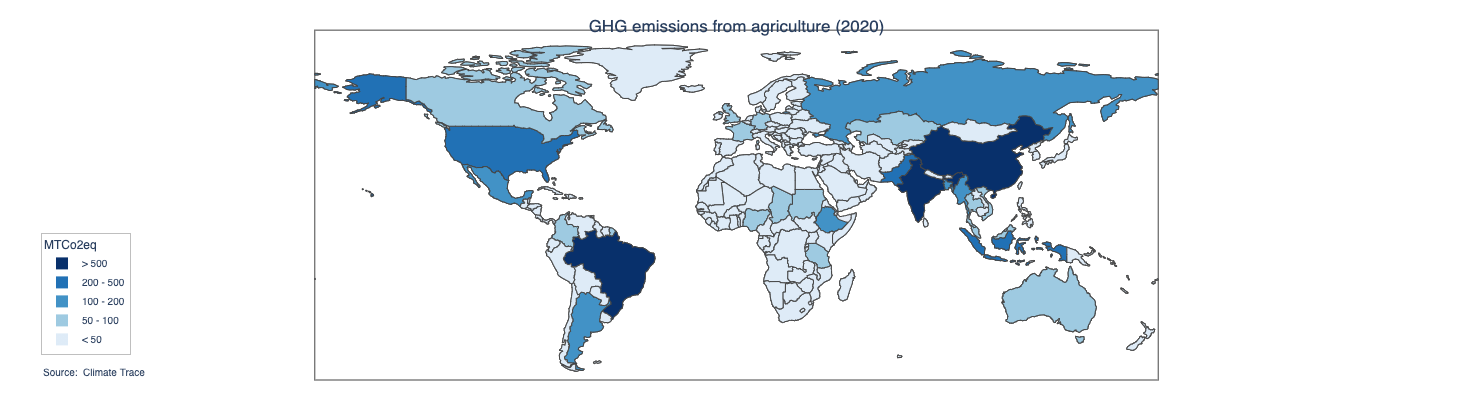

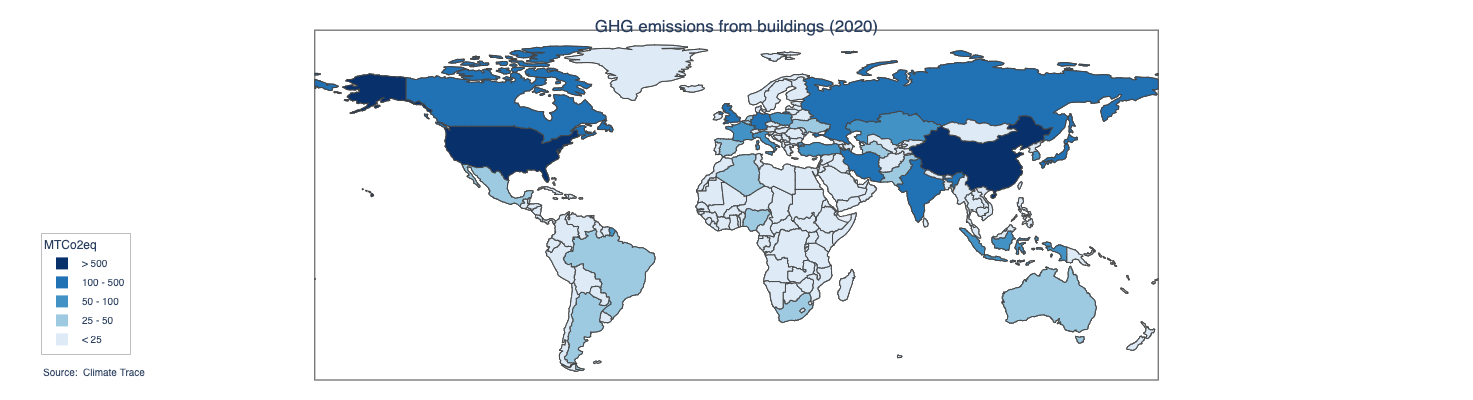

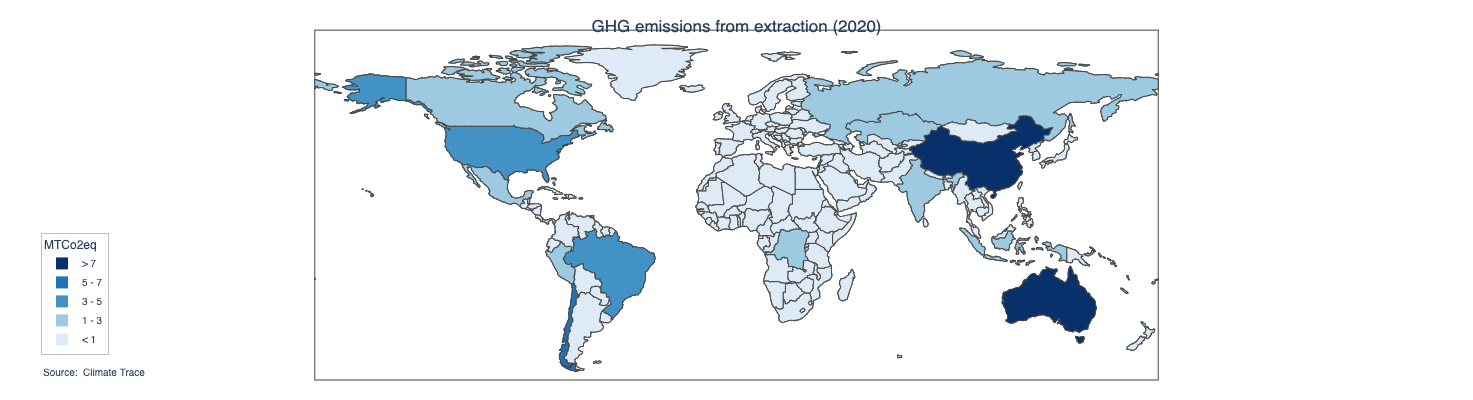

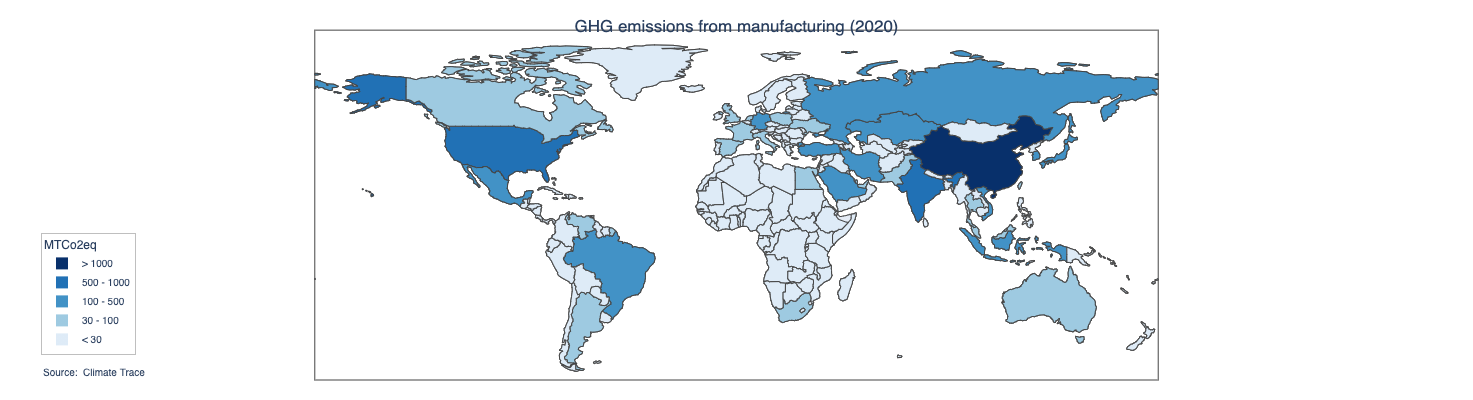

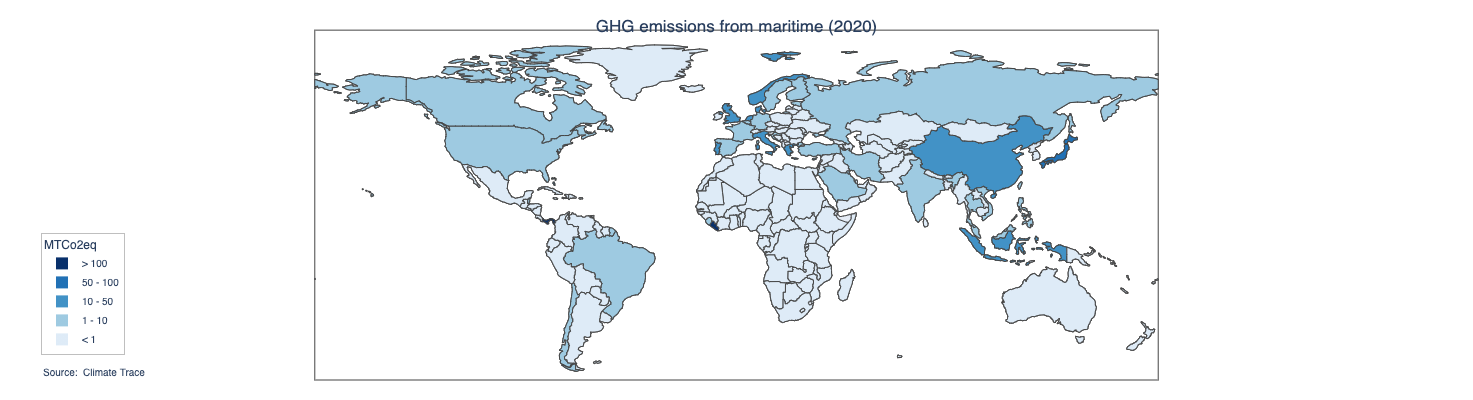

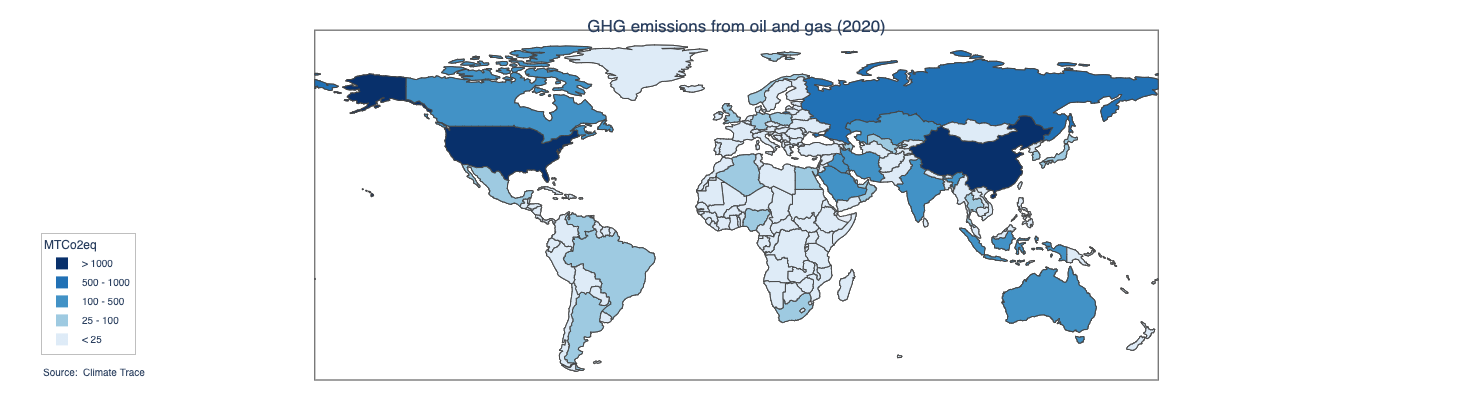

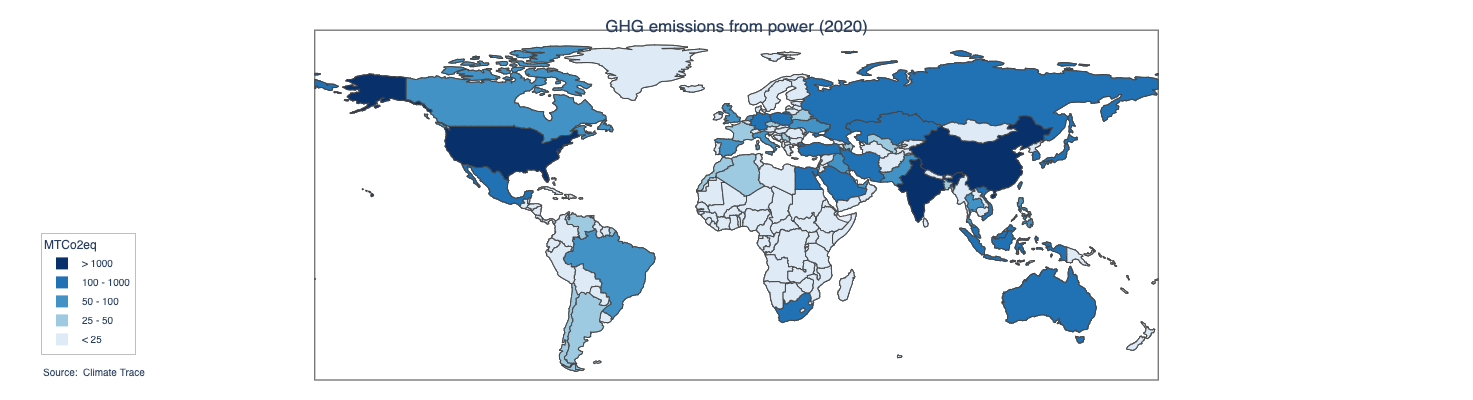

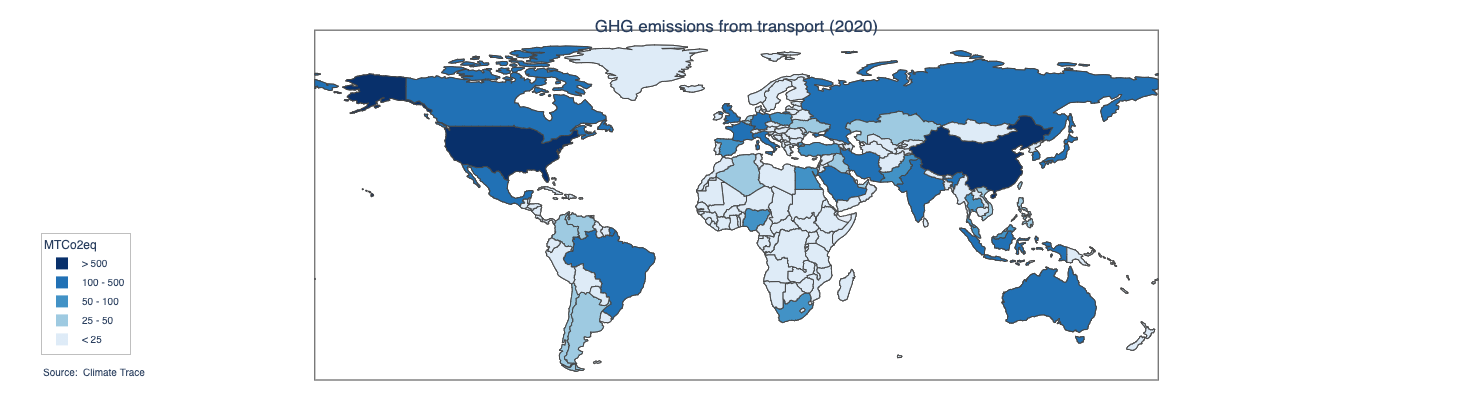

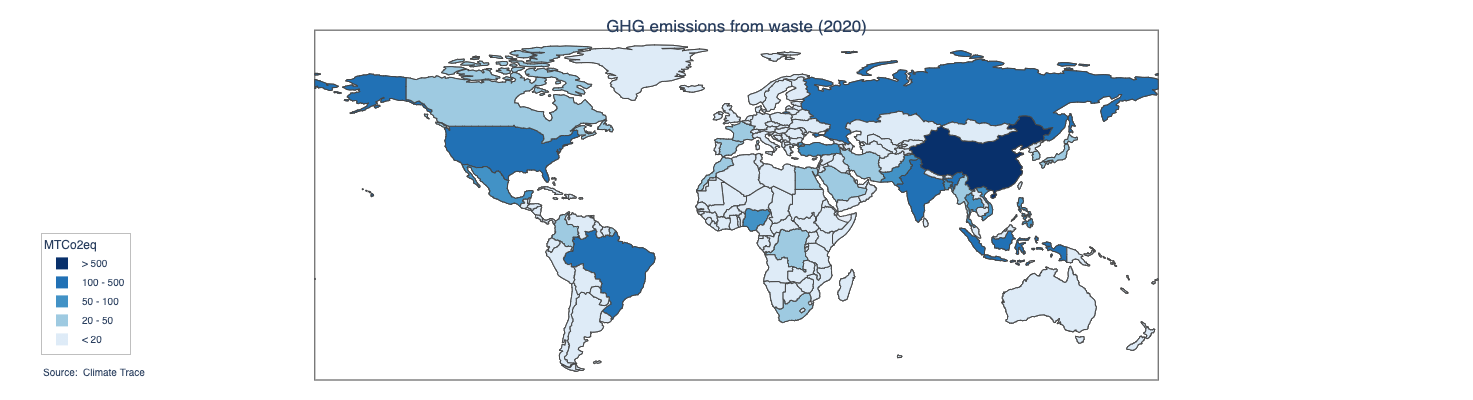

In [4466]:
for sector in ghg.sector.unique():
    show_map_sector(sector, '2020')

### 5. Emissions by country, sector or subsector

In [1363]:
def emissions_sector_subsector(df, country='global', sector='all', year):
    
    if (country == 'all') & (sector =='all') & (year=='all'):
        
        df_year_sector_country = df[(df.year==year) & (df.sector==sector) & (df.country_full==country)]
        
        ax = ghg.groupby('sector')['million_tonnes_co2e'].mean().sort_values(ascending=False).plot.bar(figsize=(8,5))
        ax.set_title('Global emissions by sector')
        plt.xticks(rotation=45, ha="right")
        plt.show()
        
    elif (country =='all') & (sector !='all'):
        ghg_all_sector = ghg[ghg.sector ==sector]
        ax = ghg_all_sector.groupby('subsector')['Tonnes Co2e'].sum().sort_values(ascending=False).plot.bar(figsize=(8,5))
        ax.set_title('Global emissions of {sector} by subsector'.format(sector =sector))
        plt.xticks(rotation=45, ha="right")
        plt.show()
        
        
    elif (country != 'all') & (sector =='all'):
        ghg_country = ghg[ghg.country_full==country]
        ax = ghg_country.groupby('sector')['Tonnes Co2e'].sum().sort_values(ascending=False).plot.bar(figsize=(8,5))
        ax.set_title('{name} emissions by sector'.format(name=country))
        plt.xticks(rotation=45, ha="right")
        plt.show()
    elif (country != 'all') & (sector != 'all'):
        ghg_country_sector = ghg[(ghg.sector ==sector) & (ghg.country_full ==country)]
        
        ax = ghg_country_sector.groupby('subsector')['Tonnes Co2e'].sum().sort_values(ascending=False).plot.bar(figsize=(8,5))
        ax.set_title('{name} {sector} emissions by subsector'.format(sector =sector,name=country))
        plt.xticks(rotation=45, ha="right")
        plt.show()
                    
        


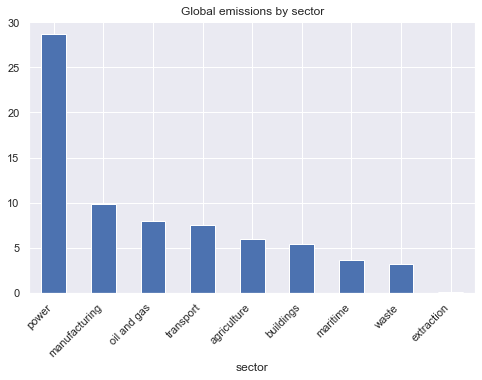

In [1365]:
emissions_sector_subsector('all','all')

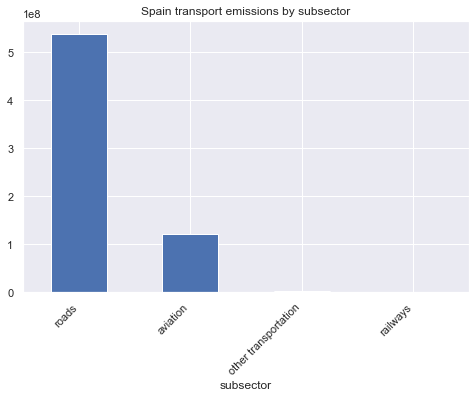

In [282]:
emissions_sector_subsector('Spain','transport')

### 5. Emission and Popullation

In [386]:
ghg['co2_per_pop'] = ghg['Tonnes Co2e'] / ghg['population']

In [479]:
emissions_year = ghg.groupby(['country','country_full','year']).agg({'Tonnes Co2e': 'sum'}).reset_index()
emissions_year= emissions_year.merge(pop_15_20, on=['country','year'], how='left')
emissions_year= emissions_year.merge(pib_15_20, on=['country','year'], how='left')

In [480]:
emissions_year['emissions_per_cap'] =emissions_year['Tonnes Co2e'] /emissions_year['population']

In [482]:
emissions_avg =(emissions_year.groupby('country_full')[['Tonnes Co2e','population','pib','emissions_per_cap']].mean() 
            .sort_values(by='pib', ascending=False).reset_index()
)

                                                                             

In [483]:
emissions_avg = emissions_avg.dropna(subset=['population'])

In [484]:
emissions_avg

,country_full,Tonnes Co2e,population,pib,emissions_per_cap
0,United States of America,6.408903e+09,3.255975e+08,1.991801e+13,19.686346
1,China,1.325093e+10,1.388140e+09,1.291712e+13,9.544718
2,Japan,1.368103e+09,1.265919e+08,4.839712e+12,10.806615
3,Germany,9.153079e+08,8.265526e+07,3.687709e+12,11.076861
4,United Kingdom of Great Britain and Northern I...,5.096554e+08,6.621644e+07,2.780732e+12,7.701948
...,...,...,...,...,...
222,Gibraltar,2.941592e+06,3.371917e+04,NaN,87.241836
231,New Caledonia,5.324800e+06,2.703267e+05,NaN,19.695582
238,Saint Martin (French Part),3.997833e+03,3.707000e+04,NaN,0.108214
242,Syrian Arab Republic,3.753689e+07,1.734575e+07,NaN,2.164005


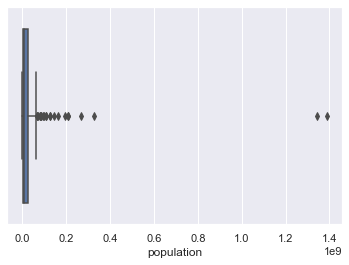

In [466]:
sns.boxplot(x=emissions_avg["population"])
plt.show()

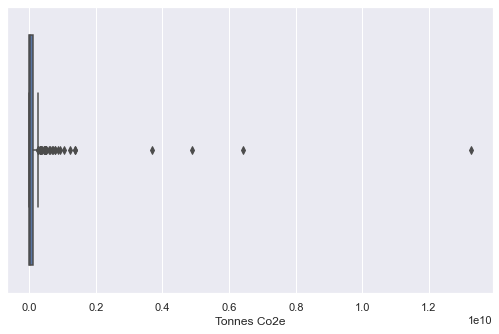

In [433]:
sns.boxplot(x=emissions_avg["Tonnes Co2e"])
plt.show()

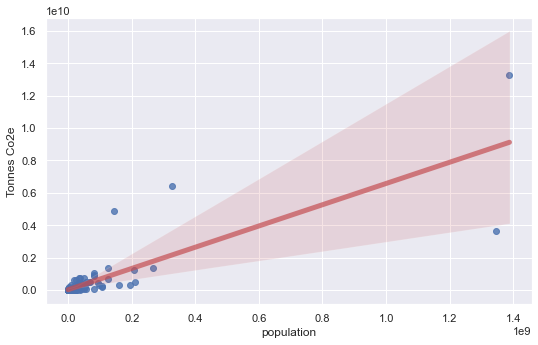

In [426]:
sns.regplot(y=emissions_avg["Tonnes Co2e"], x=emissions_avg["population"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

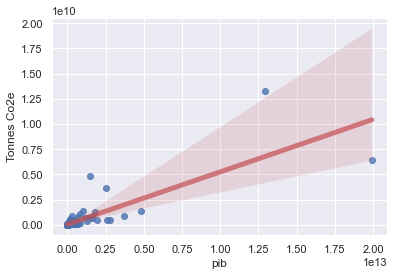

In [461]:
sns.regplot(y=emissions_avg["Tonnes Co2e"], x=emissions_avg["pib"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

In [494]:
emissions_year_pivot = emissions_year.pivot_table(values='emissions_per_cap',columns='country_full',index='year')

In [522]:
most_pollutant_countries= list(emissions_country_ghg.head(10).reset_index()['country_full'])

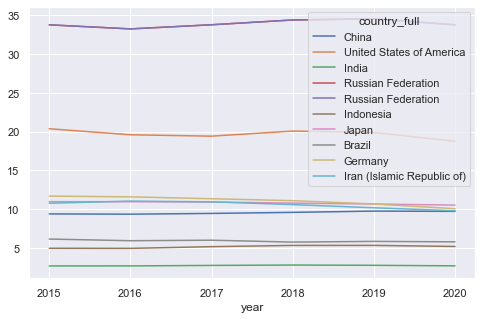

In [523]:
(emissions_year_pivot.T.sort_values(by='2020', ascending=False )
                    .T.reset_index()
                     .plot(x="year", y=most_pollutant_countries, figsize=(8,5))
)
plt.show()

In [454]:

fig = px.choropleth(emissions_2020, locations="country_full", 
                    locationmode='country names', color="population", 
                    hover_name="country_full", range_color=[1,1000], 
                    color_continuous_scale="blues")

